## 前置代码
### 引用类库，添加需要的函数

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pandas as pd
import matplotlib
%matplotlib inline

In [2]:
def GetNewDataByPandas():
    wine = pd.read_csv("/home/fonttian/Data/UCI/wine/wine.csv")
    wine['alcohol**2'] = pow(wine["alcohol"], 2)
    wine['volatileAcidity*alcohol'] = wine["alcohol"] * wine['volatile acidity']
    y = np.array(wine.quality)
    X = np.array(wine.drop("quality", axis=1))
    # X = np.array(wine)

    columns = np.array(wine.columns)

    return X, y, columns

### 直接从csv加载亦可

In [3]:
file_path = "/home/fonttian/Data/UCI/wine/wine.csv"
data = np.genfromtxt(file_path, delimiter=',')
dtrain_2 = xgb.DMatrix(data[1:1119, 0:11], data[1:1119, 11])
dtest_2 = xgb.DMatrix(data[1119:1599, 0:11], data[1119:1599, 11])

## 加载数据
### 读取数据并分割

In [4]:
# Read wine quality data from file
X, y, wineNames = GetNewDataByPandas()
# X, y, wineNames = GetDataByPandas()
# split data to [0.8,0.2,01]
x_train, x_predict, y_train, y_predict = train_test_split(X, y, test_size=0.10, random_state=100)


# take fixed holdout set 30% of data rows
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=100)

### 展示数据

In [5]:
wineNames

array(['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality', 'alcohol**2', 'volatileAcidity*alcohol'], dtype=object)

In [6]:
print(len(x_train),len(y_train))
print(len(x_test))
print(len(x_predict))

1151 1151
288
160


### 加载到DMatrix
 1. 其中missing将作为填充缺失数值的默认值，可不填
 2. 必要时也可以设置权重

In [7]:
dtrain = xgb.DMatrix(data=x_train,label=y_train,missing=-999.0)
dtest = xgb.DMatrix(data=x_test,label=y_test,missing=-999.0)

# w = np.random.rand(5, 1)
# dtrain = xgb.DMatrix(x_train, label=y_train, missing=-999.0, weight=w)

## 设定参数
### Booster参数

In [8]:
param = {'max_depth': 7, 'eta': 1, 'silent': 1, 'objective': 'reg:linear'}
param['nthread'] = 4
param['seed'] = 100
param['eval_metric'] = 'auc'

### 还可以指定多个ecal指标

In [9]:
param['eval_metric'] = ['auc', 'ams@0']
# 此处我们进行回归运算，只设置rmse
param['eval_metric'] = ['rmse']
param['eval_metric']

['rmse']

### 指定设置为监视性能的验证

In [10]:
evallist = [(dtest, 'eval'), (dtrain, 'train')]

## 训练
### 训练模型

在之前的代码中，我将数据分割为 6:3:1，其分别为，训练数据，性能监视用数据，和最后的预测数据。这个比例只是为了示例用，并不具有代表性。

在数据集不足的情况下，除预测数据外，也可以不分割训练集与验证集，使用交叉验证方法，不适用性能监视数据（验证集）有时也是可行的。请自行思考，进行选择。

In [11]:
num_round = 10
bst_without_evallist = xgb.train(param, dtrain, num_round)

In [12]:
num_round = 10
bst_with_evallist = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-rmse:0.793859	train-rmse:0.68806
[1]	eval-rmse:0.796485	train-rmse:0.474253
[2]	eval-rmse:0.796662	train-rmse:0.450195
[3]	eval-rmse:0.778571	train-rmse:0.400886
[4]	eval-rmse:0.789566	train-rmse:0.340342
[5]	eval-rmse:0.798235	train-rmse:0.27816
[6]	eval-rmse:0.804898	train-rmse:0.244093
[7]	eval-rmse:0.813786	train-rmse:0.212835
[8]	eval-rmse:0.81194	train-rmse:0.190969
[9]	eval-rmse:0.814219	train-rmse:0.159447


### 模型持久化

In [13]:
models_path = "/home/fonttian/Models/Sklearn_book/xgboost/"
bst_with_evallist.save_model(models_path+'bst_with_evallist_0001.model')

### 模型与特征映射也可以转存到文本文件中

In [14]:
# dump model
bst_with_evallist.dump_model(models_path+'dump.raw.txt')
# dump model with feature map
bst_with_evallist.dump_model(models_path+'dump.raw.txt', models_path+'featmap.txt')

### 可以按如下方式加载已保存的模型：

In [15]:
bst_with_evallist = xgb.Booster({'nthread': 4})  # init model
bst_with_evallist.load_model(models_path+'bst_with_evallist_0001.model')  # load data

## 早停

如果您有一个验证集, 你可以使用提前停止找到最佳数量的 boosting rounds（梯度次数）. 提前停止至少需要一个 evals 集合. 如果有多个, 它将使用最后一个.
```python
train(..., evals=evals, early_stopping_rounds=10)
```
该模型将开始训练, 直到验证得分停止提高为止. 验证错误需要至少每个 early_stopping_rounds 减少以继续训练.

如果提前停止，模型将有三个额外的字段: bst.best_score, bst.best_iteration 和 bst.best_ntree_limit. 请注意 train() 将从上一次迭代中返回一个模型, 而不是最好的一个.

这与两个度量标准一起使用以达到最小化（RMSE, 对数损失等）和最大化（MAP, NDCG, AUC）. 请注意, 如果您指定多个评估指标, 则 param ['eval_metric'] 中的最后一个用于提前停止.

In [16]:
bst_with_evallist_and_early_stopping_10 = xgb.train(param, dtrain, num_round*100, evallist,early_stopping_rounds=10)

[0]	eval-rmse:0.793859	train-rmse:0.68806
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-rmse:0.796485	train-rmse:0.474253
[2]	eval-rmse:0.796662	train-rmse:0.450195
[3]	eval-rmse:0.778571	train-rmse:0.400886
[4]	eval-rmse:0.789566	train-rmse:0.340342
[5]	eval-rmse:0.798235	train-rmse:0.27816
[6]	eval-rmse:0.804898	train-rmse:0.244093
[7]	eval-rmse:0.813786	train-rmse:0.212835
[8]	eval-rmse:0.81194	train-rmse:0.190969
[9]	eval-rmse:0.814219	train-rmse:0.159447
[10]	eval-rmse:0.813085	train-rmse:0.140323
[11]	eval-rmse:0.819273	train-rmse:0.120302
[12]	eval-rmse:0.818706	train-rmse:0.100072
[13]	eval-rmse:0.817335	train-rmse:0.082629
[14]	eval-rmse:0.816187	train-rmse:0.076443
[15]	eval-rmse:0.818007	train-rmse:0.065134
[16]	eval-rmse:0.820298	train-rmse:0.057569
[17]	eval-rmse:0.821501	train-rmse:0.050076
[18]	eval-rmse:0.823743	train-rmse:0.040977
[19]	eval-rmse:0.82361	train-rms

In [17]:
bst_with_evallist_and_early_stopping_100 = xgb.train(param, dtrain, num_round*100, evallist,early_stopping_rounds=100)

[0]	eval-rmse:0.793859	train-rmse:0.68806
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 100 rounds.
[1]	eval-rmse:0.796485	train-rmse:0.474253
[2]	eval-rmse:0.796662	train-rmse:0.450195
[3]	eval-rmse:0.778571	train-rmse:0.400886
[4]	eval-rmse:0.789566	train-rmse:0.340342
[5]	eval-rmse:0.798235	train-rmse:0.27816
[6]	eval-rmse:0.804898	train-rmse:0.244093
[7]	eval-rmse:0.813786	train-rmse:0.212835
[8]	eval-rmse:0.81194	train-rmse:0.190969
[9]	eval-rmse:0.814219	train-rmse:0.159447
[10]	eval-rmse:0.813085	train-rmse:0.140323
[11]	eval-rmse:0.819273	train-rmse:0.120302
[12]	eval-rmse:0.818706	train-rmse:0.100072
[13]	eval-rmse:0.817335	train-rmse:0.082629
[14]	eval-rmse:0.816187	train-rmse:0.076443
[15]	eval-rmse:0.818007	train-rmse:0.065134
[16]	eval-rmse:0.820298	train-rmse:0.057569
[17]	eval-rmse:0.821501	train-rmse:0.050076
[18]	eval-rmse:0.823743	train-rmse:0.040977
[19]	eval-rmse:0.82361	train-rm

## 预测
### 预测结果
当您 训练/加载 一个模型并且准备好数据之后, 即可以开始做预测了.

In [18]:
dpredict = xgb.DMatrix(x_predict)
# 啥都没有
ypred_without_evallist = bst_without_evallist.predict(dpredict)
# 没有早停
ypred_with_evallist = bst_with_evallist.predict(dpredict)
#有早停
ypred_with_evallist_and_early_stopping_100 = bst_with_evallist_and_early_stopping_100.predict(dpredict,ntree_limit=bst_with_evallist_and_early_stopping_100.best_ntree_limit)

### 测试误差

现在我们就可以对之前三种数据使用模式得到的模型进行性能对比。效果如下。不过值得注意的是，本处代码重在展示使用方法，并不代表普适性。实际上，这里模型的最终效果表现确实也十分糟糕，我会在更之后的博客中，在同一数据集上展示其他使用方法和数据挖掘技巧，最终获得效果更加明显的模型。

In [19]:
from sklearn.metrics import mean_squared_error
print("RMSE of bst_without_evallist ：", np.sqrt(mean_squared_error(y_true=y_predict,y_pred=ypred_without_evallist)))

print("RMSE of bst_with_evallist ：", np.sqrt(mean_squared_error(y_true=y_predict,y_pred=ypred_with_evallist)))

print("RMSE of bst_with_evallist_and_early_stopping_100 ：", np.sqrt(mean_squared_error(y_true=y_predict,y_pred=ypred_with_evallist_and_early_stopping_100)))

RMSE of bst_without_evallist ： 0.7115641528672897
RMSE of bst_with_evallist ： 0.7115641528672897
RMSE of bst_with_evallist_and_early_stopping_100 ： 0.7051095825211103



## 绘图
您可以使用 plotting（绘图）模块来绘制出 importance（重要性）以及输出的 tree（树）.如果需要直接输出重要程度排名的话，则可以使用`get_score`方法或者`get_fscore`方法，两者不同之处在于前者可以通过`importance_type`参数添加权重。

要绘制出 importance（重要性）, 可以使用 plot_importance. 该函数需要安装 matplotlib.

In [39]:
bst_with_evallist_and_early_stopping_100.get_score()

{'f10': 169,
 'f3': 227,
 'f1': 333,
 'f9': 243,
 'f12': 250,
 'f8': 237,
 'f2': 270,
 'f4': 269,
 'f6': 276,
 'f0': 479,
 'f7': 280,
 'f5': 235}

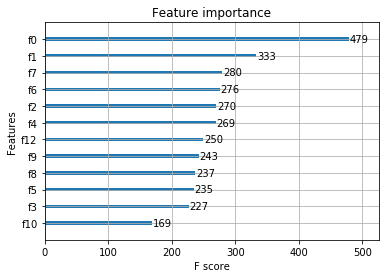

In [21]:
xgb.plot_importance(bst_with_evallist_and_early_stopping_100)

输出的 tree（树）会通过 `matplotlib` 来展示, 使用 `plot_tree` 指定 `target tree`（目标树）的序号. 该函数需要 `graphviz` 和 `matplotlib`.而且有一点要注意的是`graphviz`不仅仅是需要通过`pip install graphviz`来安装，还需要在你的系统中安装该软件，否则xgboost中的该部分将无法使用。此处可以参考[我的另外一篇文章](https://blog.csdn.net/FontThrone/article/details/84765478)

除此之外我们还需要为`plot_tree`输入一个	`matplotlib`的ax，以控制输出图片的尺寸。

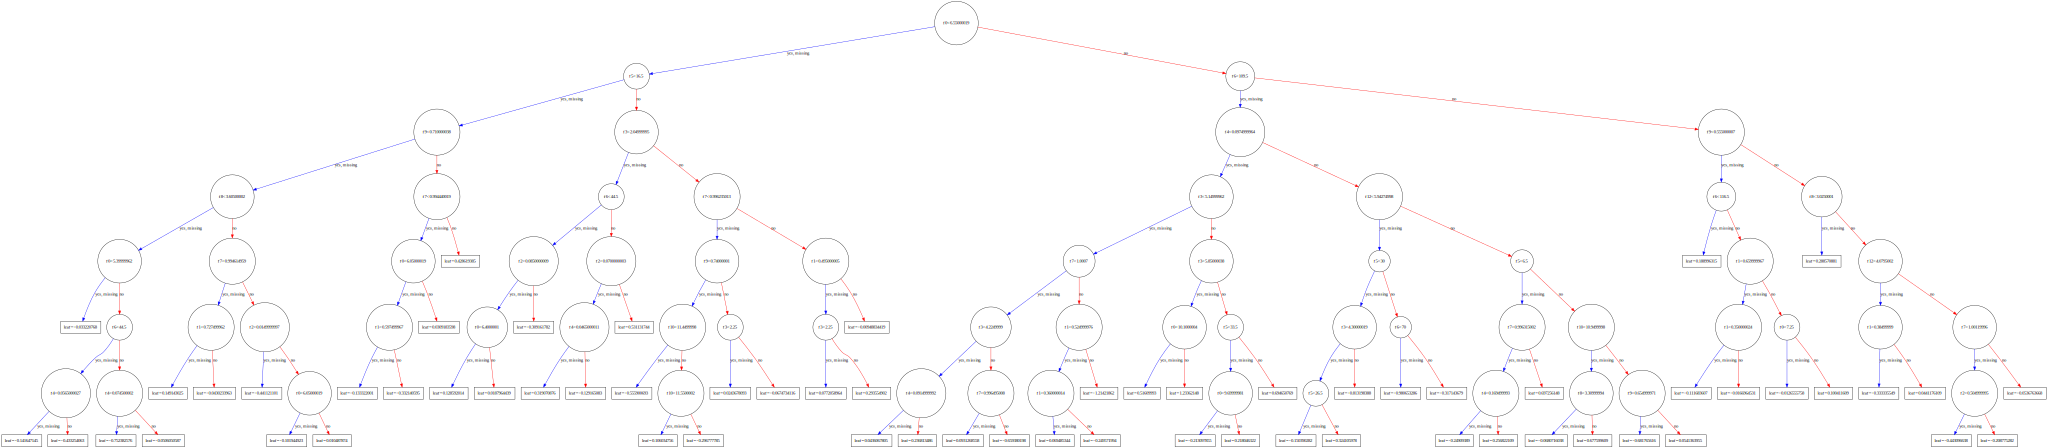

In [50]:
# xgb.plot_tree(bst, num_trees=2)
xgb.to_graphviz(bst_with_evallist_and_early_stopping_100, num_trees=2)

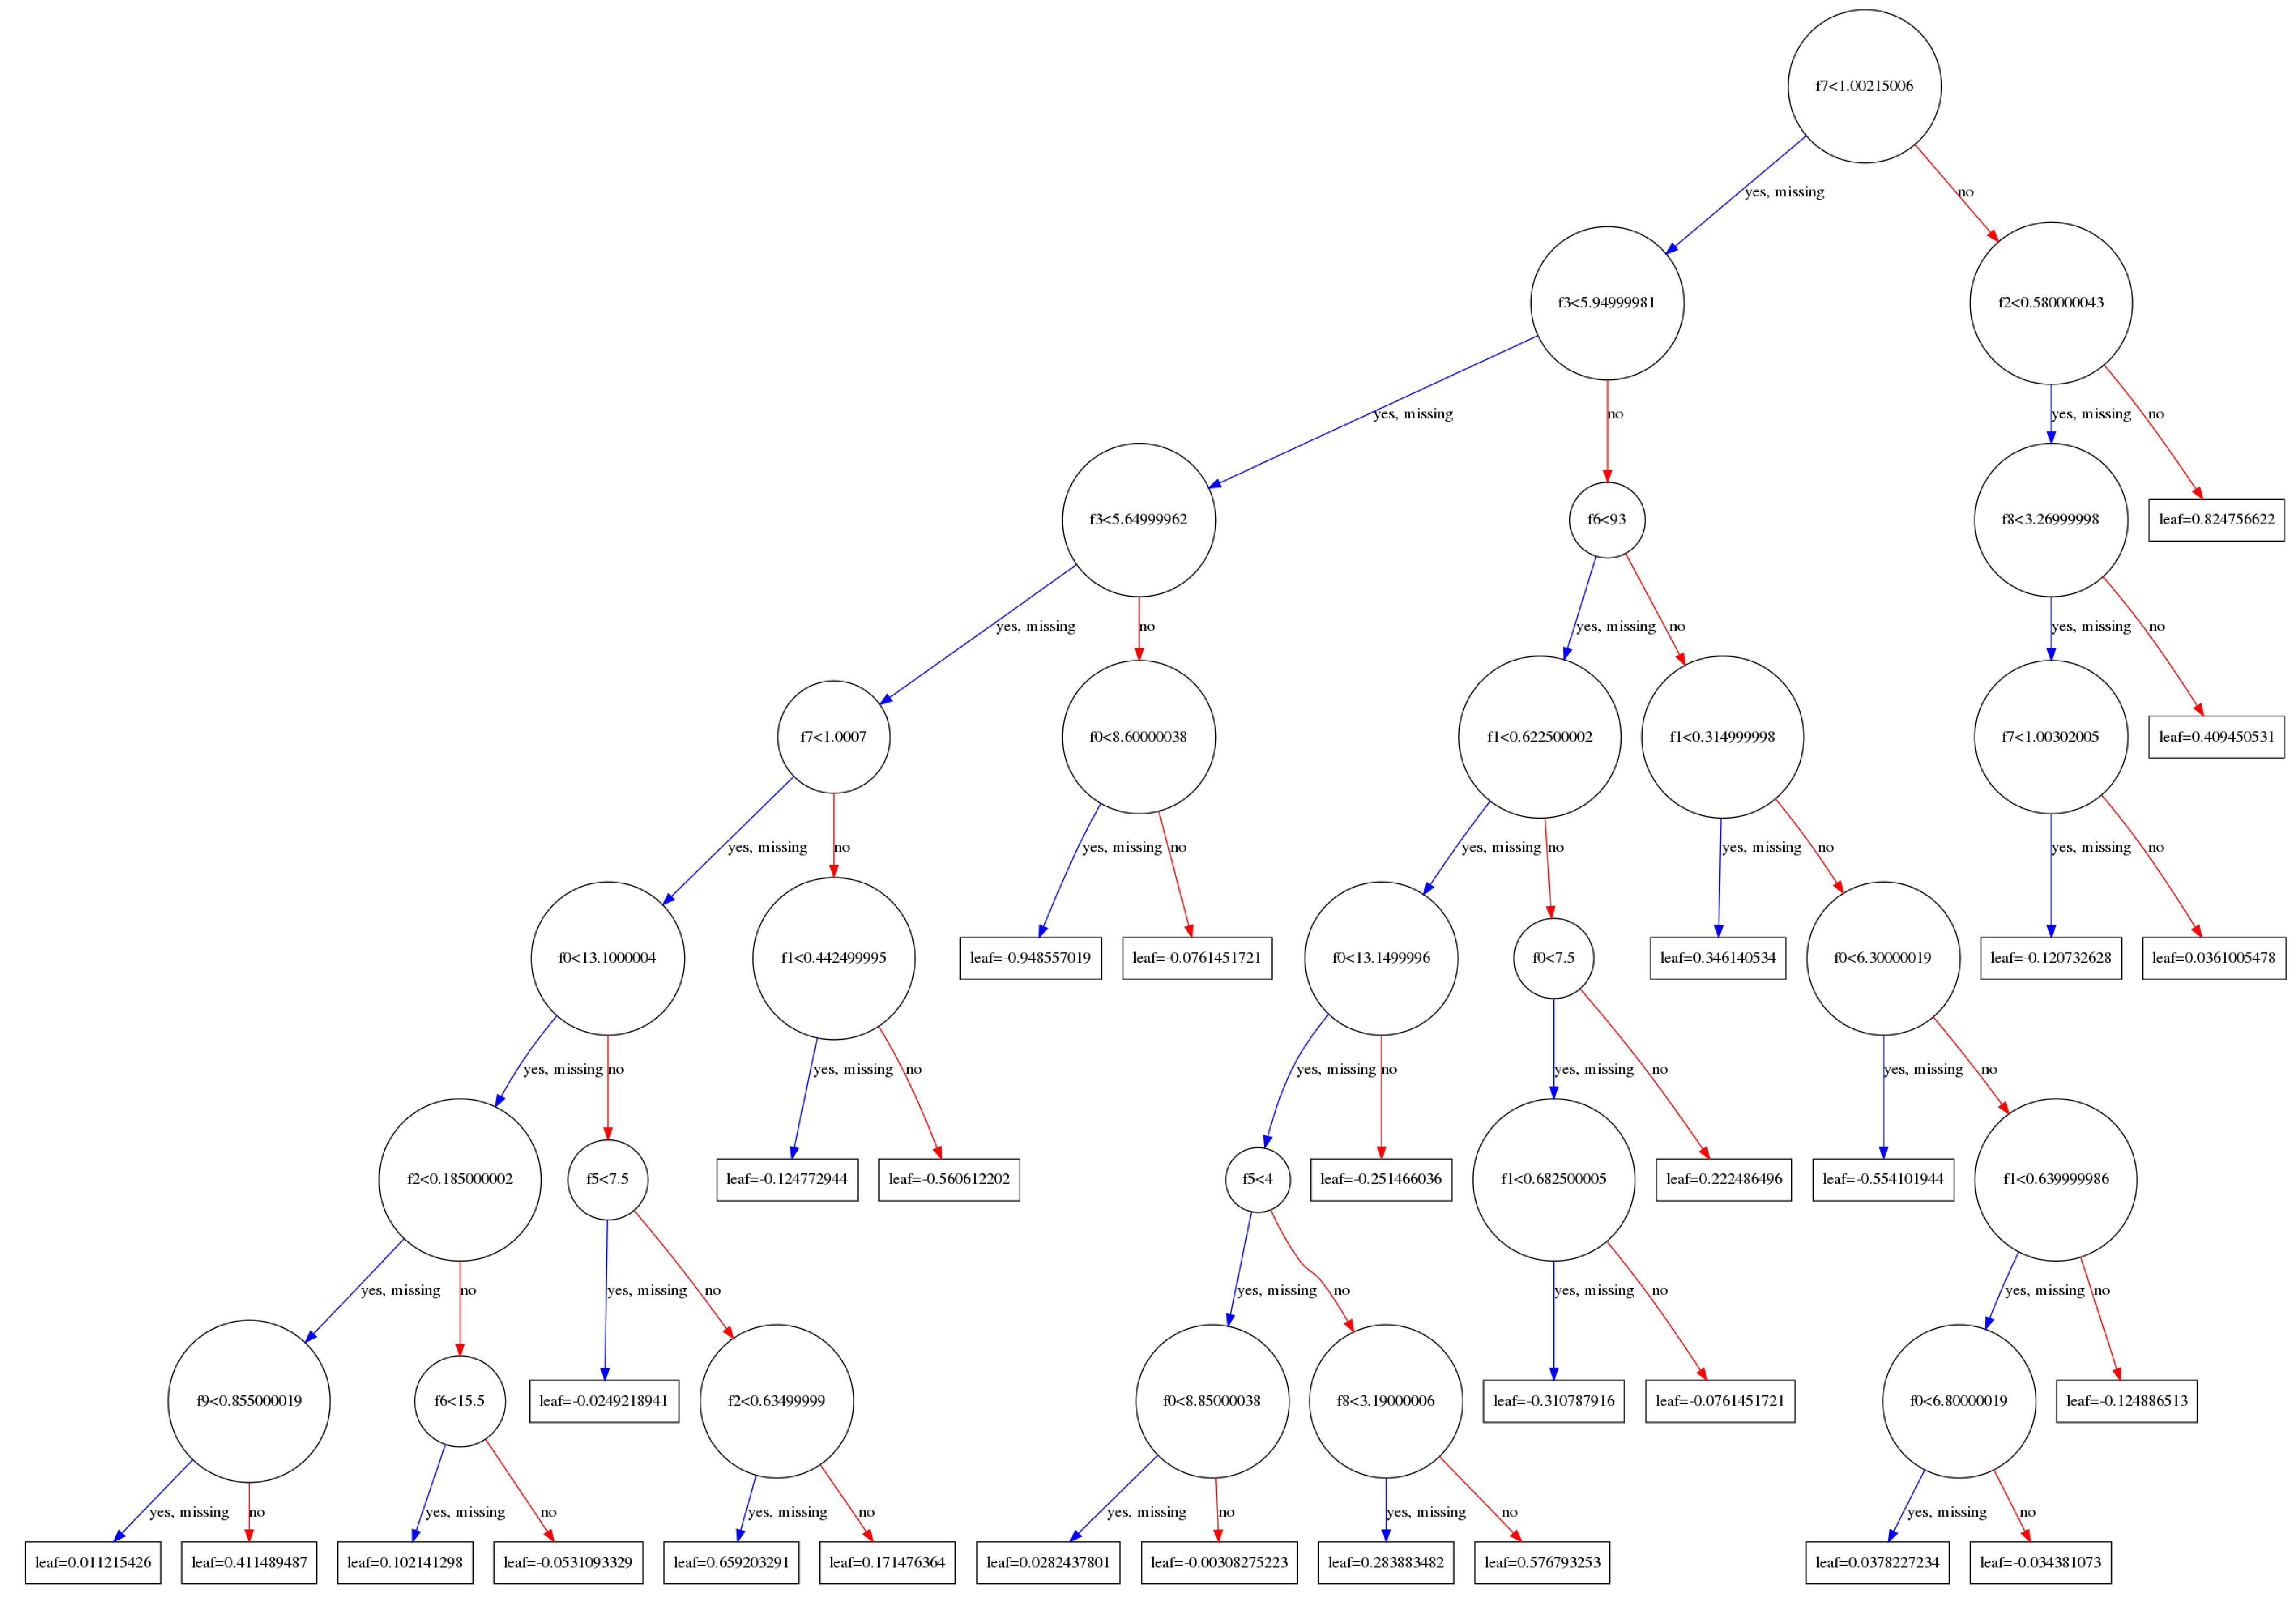

In [36]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([18.5,18.5,10.5,10.5])
xgb.plot_tree(bst_with_evallist_and_early_stopping_100, num_trees=2,ax=ax)
plt.show()